In [2]:
import os 
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Conv2D, Conv3D
from tensorflow.keras.layers import MaxPool2D, MaxPool3D, Flatten, Dense
from tensorflow.keras import Model

import tensorflow as tf
import tf2onnx
import onnx

import onnxruntime as ort
import numpy as np

import cv2
import io

import matplotlib.pyplot as plt

In [9]:
# 檢查GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 高光譜轉換模型

In [10]:
class SpectrumTransfer:
    
    def __init__(self):
        self.extend_mode = 0
        self.B = None
        self.C = None
        self.M = None
        self.TransM = None
        self.TransMin = 0.0
        self.TransMax = 1.0
        
    def get_extend(self, src_rgb):
        
        extend = None

        if self.extend_mode == 0:
            extend = np.array([src_rgb[:,0], src_rgb[:,1], src_rgb[:,2], np.power(src_rgb[:,0],2), np.power(src_rgb[:,1],2), np.power(src_rgb[:,2],2)])
        elif self.extend_mode == 1:
            extend = np.array([src_rgb[:,0], src_rgb[:,1], src_rgb[:,2], np.power(src_rgb[:,0],2), np.power(src_rgb[:,1],2), np.power(src_rgb[:,2],2),src_rgb[:,0]* src_rgb[:,1],src_rgb[:,0]* src_rgb[:,2],src_rgb[:,1]* src_rgb[:,2]])
        elif self.extend_mode == 2:
            extend = np.array([src_rgb[:,0], src_rgb[:,1], src_rgb[:,2], np.power(src_rgb[:,0],2), np.power(src_rgb[:,1],2), np.power(src_rgb[:,2],2),src_rgb[:,0]* src_rgb[:,1],src_rgb[:,0]* src_rgb[:,2],src_rgb[:,1]* src_rgb[:,2], np.power(src_rgb[:,0],3), np.power(src_rgb[:,1],3), np.power(src_rgb[:,2],3)])

        return extend
    
    def prepare(self):
        self.TransM = np.dot(self.M.T, self.B)
        return
    
    def load(self, setup_file):
        weight = np.load(setup_file)
        
        self.M = weight["a"]
        self.B = weight["b"]
        self.C = weight["c"]
        
#         self.TransMin = weight['d'][0]
#         self.TransMax = weight['d'][1]
        
        self.extend_mode = weight['e'][0]
        
        self.prepare()
        
        return
 
    def transfer1D(self, src_data):
        
        src_data = src_data.astype(np.float32)

        tar_sepc = np.dot(self.get_extend(src_data).T, self.TransM) + self.C
        
        tar_sepc = (tar_sepc - self.TransMin) / (self.TransMax - self.TransMin)

        return tar_sepc
    
    def transfer(self, src_data):
        
        src_data = src_data.astype(np.float32)
        
        src_shape = src_data.shape

        if len(src_shape) >= 3:
            src_data = src_data.reshape(-1, src_shape[-1])

        tar_sepc = np.dot(self.get_extend(src_data).T, self.TransM) + self.C

        if len(src_shape) >= 3:
            tar_sepc = tar_sepc.持reshape(src_shape[0:-1] + tuple([self.C.shape[0]]))
        
        tar_sepc = (tar_sepc - self.TransMin) / (self.TransMax - self.TransMin)
        
        return tar_sepc

建立LUT

COLOR -> SPECTRUM

RGB 0-255

256*256*256 *401

# 資料產生器

In [11]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, data_path:str, shuffle=True, batch_size = 4, image_shape = (64,64,11)):
        'Initialization'        
        self.transfer = SpectrumTransfer()
        self.transfer.load("weight.npz")
        
        self.data_path = data_path
        self.path_list = os.listdir(data_path) # 列出所有圖片檔名  
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.on_epoch_end()
        
        self.n_classes = 4
        
        self.label_dict = dict()
        self.label_dict['good'] = 1.0/4.0
        self.label_dict['normal'] = 2.0/4.0
        self.label_dict['unhealthy'] = 3.0/4.0
        self.label_dict['very unhealthy'] = 4.0/4.0
        
        self.data_dict = dict()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.path_list) / self.batch_size))
    
    def __getitem__(self, index: int):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
             
    def __data_generation(self, tar_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        
        X = np.empty(([self.batch_size] + list(self.image_shape)))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, ID in enumerate(tar_ids):
            
            trans_spec = None
            label = None
            
            if (ID in self.data_dict):
                trans_spec, label = self.data_dict[ID]
            else:
                
                img_path = self.path_list[ID]

                img_key = img_path.split('.')[0]

                label = self.label_dict.get(img_key, -1)

                img_path = os.path.join(self.data_path, img_path)# 取得圖片完整路徑
                np_img = cv2.imread(img_path)

                trans_spec = self.transfer.transfer(np_img)[:,:,::40].astype('float32')
                
                self.data_dict[ID] = [trans_spec, label]
             
            X[i,] = trans_spec
            y[i] = label

        return X, y

# 定義模型

In [12]:
# input  
input_data = Input(shape =(64,64,11,1))

# 1st Conv Block
x = Conv3D (filters =8, kernel_size =3, padding ='same', activation='relu')(input_data)
x = MaxPool3D(pool_size =2, strides =2, padding ='same')(x)

# 2nd Conv Block
x = Conv3D (filters =16, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool3D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block  
x = Conv3D (filters =32, kernel_size =3, padding ='same', activation='relu')(x)  
x = MaxPool3D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers  
x = Flatten()(x) 
x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 256, activation ='relu')(x) 
output_data = Dense(units = 1)(x)

# creating the model
model = Model (inputs=input_data, outputs=output_data)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 11, 1)]   0         
                                                                 
 conv3d_3 (Conv3D)           (None, 64, 64, 11, 8)     224       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 32, 32, 6, 8)     0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 32, 32, 6, 16)     3472      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 16, 16, 3, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 16, 16, 3, 32)     1385

In [13]:
model.compile(optimizer='sgd', loss='mse', metrics=['accuracy', 'MeanSquaredError'])

# 訓練模型

In [21]:
epochs = 100

train_data_path = 'D:\\AIR POLUTION\\TEST\\SplitTraining\\Train'
test_data_path = 'D:\\AIR POLUTION\\TEST\\SplitTraining\\Test'

shuffle=True
batch_size = 4
image_shape = (64,64,11)

train_generator = DataGenerator(train_data_path, shuffle, batch_size, image_shape)
test_generator = DataGenerator(test_data_path, shuffle, batch_size, image_shape)

# Train model on dataset
history = model.fit(x=train_generator,epochs=epochs, validation_data = test_generator)

Epoch 1/100
1943/1943 [==============================] - 201s 104ms/step - loss: 0.0170 - accuracy: 0.0000e+00 - mean_squared_error: 0.0170 - val_loss: 0.0213 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0213
Epoch 2/100
1943/1943 [==============================] - 33s 17ms/step - loss: 0.0120 - accuracy: 0.0000e+00 - mean_squared_error: 0.0120 - val_loss: 0.0175 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0175
Epoch 3/100
1943/1943 [==============================] - 33s 17ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - mean_squared_error: 0.0097 - val_loss: 0.0190 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0190
Epoch 4/100
1943/1943 [==============================] - 34s 17ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - mean_squared_error: 0.0074 - val_loss: 0.0205 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0205
Epoch 5/100
1943/1943 [==============================] - 33s 17ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_squared_error:

Epoch 38/100
1943/1943 [==============================] - 32s 17ms/step - loss: 1.0974e-05 - accuracy: 0.0000e+00 - mean_squared_error: 1.0974e-05 - val_loss: 0.0125 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0125
Epoch 39/100
1943/1943 [==============================] - 32s 17ms/step - loss: 9.8201e-06 - accuracy: 0.0000e+00 - mean_squared_error: 9.8201e-06 - val_loss: 0.0124 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0124
Epoch 40/100
1943/1943 [==============================] - 33s 17ms/step - loss: 8.7391e-06 - accuracy: 0.0000e+00 - mean_squared_error: 8.7391e-06 - val_loss: 0.0124 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0124
Epoch 41/100
1943/1943 [==============================] - 32s 17ms/step - loss: 7.7298e-06 - accuracy: 0.0000e+00 - mean_squared_error: 7.7298e-06 - val_loss: 0.0125 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 0.0125
Epoch 42/100
1943/1943 [==============================] - 32s 17ms/step - loss: 7.0326e-06 - acc

In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mean_squared_error', 'val_loss', 'val_accuracy', 'val_mean_squared_error'])


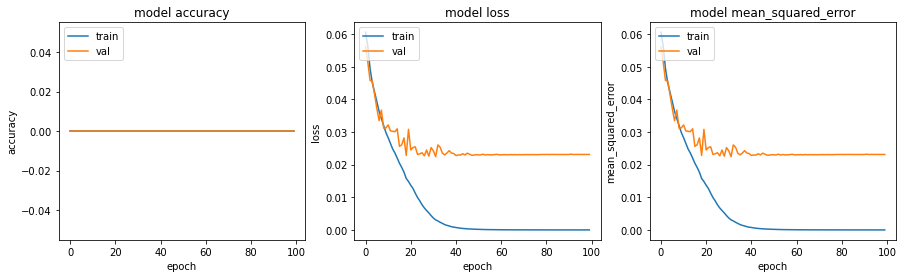

In [16]:
plt.figure(figsize=(15, 4))

#  Accuracy
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Loss
plt.subplot(1,3,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# mean_squared_error
plt.subplot(1,3,3)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 儲存模型

In [17]:
model.save('vgg3D')

INFO:tensorflow:Assets written to: vgg3D\assets


INFO:tensorflow:Assets written to: vgg3D\assets


# 匯出ONNX

In [18]:
input_signature = [tf.TensorSpec([None, 64, 64, 11, 1], tf.float32, name='x')]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(onnx_model, "model_VGG_3D_reg.onnx")

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


# 更新模型(OPTION)

In [19]:
import shutil

src_file = "model_VGG_3D_reg.onnx"
tar_file = 'D:\\SW_HS\\HSEnv\\HSEnvPredict\\HSEnvPredict\\bin\\x64\\Debug\\VGG_3D_model.onnx'

shutil.copyfile(src_file, tar_file)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SW_HS\\HSEnv\\HSEnvPredict\\HSEnvPredict\\bin\\x64\\Debug\\VGG_3D_model.onnx'